# DQN 

In [1]:
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import gymnasium as gym

In [2]:
env = gym.make("LunarLander-v3")
num_actions = 4 
state, info = env.reset()
num_observations = len(state) 


# CLASES

In [3]:
#memoria de experiencia
class Memory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)  # Almacena hasta 'capacity' transiciones
        self.batch_size = 64  # Tamaño del lote para el entrenamiento

    def cache(self, *args):
        self.memory.append(transitiones(*args))  # Guarda una transición (estado, acción, nuevo estado, recompensa)

    def recall(self):
        return random.sample(self.memory, self.batch_size)  # Obtiene un lote aleatorio de experiencias

    def __len__(self):
        return len(self.memory)


In [4]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.recall()

    batch = transitiones(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [5]:
# Se varía el uso de elegir acciones aleatorias o la de mayor recompensa, (decisión tomada en función de los mejores resultados neuroevolución)
def act(state):
    global steps
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps / EPS_DECAY)
    steps += 1
    if sample > eps_threshold:
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1) #explotacion
    else:
        action = torch.tensor([[env.action_space.sample()]], dtype=torch.long) #exploracion
    
    #print(f"Acción tomada: {action.item()}")  
    return action

In [6]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    

    if durations_t.ndimension() == 1:
        max_rewards = durations_t  
    else:
        max_rewards = durations_t.max(1)[0]  
    
    if show_result:
        plt.title('Max Reward per Episode')
    else:
        plt.clf()
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Max Reward')
    plt.plot(range(len(max_rewards)), max_rewards.numpy(),  color='red')
    
    plt.pause(0.001)  
    plt.show()

# Prueba 1
- Red Neuronal Sencilla (2 capas)
- Tamaño de Batch 64 y 128
- Función de Pérdida con Regularización
- Política Épsilon Greedy

In [7]:
# Optimizar modelo
#Calcular valores q y comparar con valores actuales para actualizar red (eq bellman 'adaptada', ver diapositivas)

transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 64)
        self.layer2 = nn.Linear(64, num_actions)  

    def forward(self, x):
        x = fun.relu(self.layer1(x))
        return self.layer2(x) 



## Batch 64

In [8]:
# HYPERPARÁMETROS
#(se controla la exploración/explotación, la tasa de aprendizaje y la actualización del target network)
BATCH_SIZE = 64
GAMMA = 0.99  # Factor de descuento para valorar recompensas futuras
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  # Decaimiento de epsilon en la exploración
TAU = 0.001  # Parámetro para actualización suave de la red objetivo
LR = 1e-4  # Tasa de aprendizaje

# REDES
policy_net = DQN(num_observations, num_actions) #Red neuronal principal que se entrena
target_net = DQN(num_observations, num_actions) #Red auxiliar que ayuda a estabilizar el entrenamiento (actualizada con TAU).
target_net.load_state_dict(policy_net.state_dict()) # senicializa target_net con los mismos pesos de policy_net
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory()


#ENTRENAMIENTO
steps = 0
episode_durations = []

EPOCHS = 100
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Almacenar transición en memoria
        memory.cache(state, action, next_state, reward)

        # Actualizar estado
        state = next_state

        # Optimizar modelo en este estado
        optimize_model()

        # Actualizar target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -94.63495029275357
Episodio 1 acabado con recompensa total: -103.73431711890376
Episodio 2 acabado con recompensa total: -244.43865600090464
Episodio 3 acabado con recompensa total: -328.4995281028475
Episodio 4 acabado con recompensa total: -192.39122350895508
Episodio 5 acabado con recompensa total: -220.85870860024494
Episodio 6 acabado con recompensa total: -42.127702806261894
Episodio 7 acabado con recompensa total: -82.84786459924692
Episodio 8 acabado con recompensa total: -414.0171554877792
Episodio 9 acabado con recompensa total: -374.1471637542101
Episodio 10 acabado con recompensa total: -412.206555323997
Episodio 11 acabado con recompensa total: -185.404317133549
Episodio 12 acabado con recompensa total: -240.50662760760034
Episodio 13 acabado con recompensa total: -297.45037308439834
Episodio 14 acabado con recompensa total: -357.71039222206014
Episodio 15 acabado con recompensa total: -458.34988508145614
Episodio 16 acabado con rec

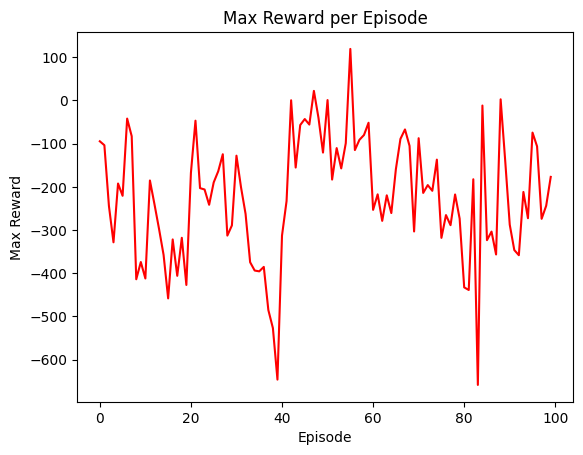

In [9]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

## Batch 128

In [10]:
transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 128)
        self.layer2 = nn.Linear(128, num_actions)  

    def forward(self, x):
        x = fun.relu(self.layer1(x))
        return self.layer2(x) 


class Memory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)  # Almacena hasta 'capacity' transiciones
        self.batch_size = 128  # Tamaño del lote para el entrenamiento

    def cache(self, *args):
        self.memory.append(transitiones(*args))  # Guarda una transición (estado, acción, nuevo estado, recompensa)

    def recall(self):
        return random.sample(self.memory, self.batch_size)  # Obtiene un lote aleatorio de experiencias

    def __len__(self):
        return len(self.memory)



In [13]:
# HYPERPARÁMETROS
BATCH_SIZE = 128
GAMMA = 0.99  
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  
TAU = 0.001  
LR = 1e-4 

# REDES
policy_net = DQN(num_observations, num_actions) 
target_net = DQN(num_observations, num_actions) 
target_net.load_state_dict(policy_net.state_dict()) 
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory()



#ENTRENAMIENTO
steps = 0
episode_durations = []

EPOCHS = 100
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Almacenar transición en memoria
        memory.cache(state, action, next_state, reward)

        # Actualizar estado
        state = next_state

        # Optimizar modelo en este estado
        optimize_model()

        # Actualizar target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -365.9307162064821
Episodio 1 acabado con recompensa total: -142.59633771363877
Episodio 2 acabado con recompensa total: -333.55380843468834
Episodio 3 acabado con recompensa total: -491.27649325190043
Episodio 4 acabado con recompensa total: -571.1946355093764
Episodio 5 acabado con recompensa total: -382.2372587739123
Episodio 6 acabado con recompensa total: -579.6198489866204
Episodio 7 acabado con recompensa total: -262.0824907469771
Episodio 8 acabado con recompensa total: -202.37424451482266
Episodio 9 acabado con recompensa total: -241.30253464975033
Episodio 10 acabado con recompensa total: -23.609300566445995
Episodio 11 acabado con recompensa total: -141.08192448534516
Episodio 12 acabado con recompensa total: -202.18353897964826
Episodio 13 acabado con recompensa total: -122.83907316544199
Episodio 14 acabado con recompensa total: -131.5430736935799
Episodio 15 acabado con recompensa total: -147.2961964227759
Episodio 16 acabado con r

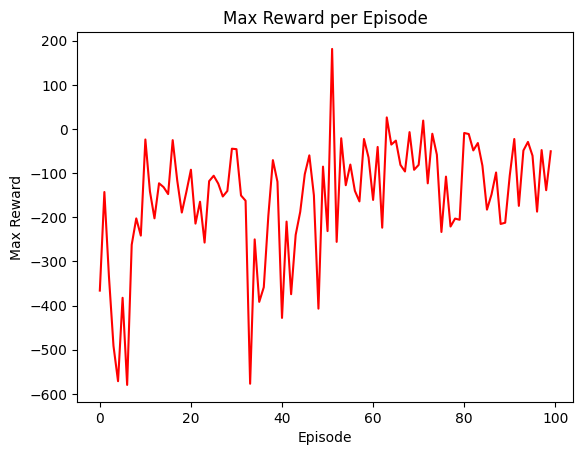

In [14]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Prueba 2
- Red Neuronal Sencilla Más Grande 
- Tamaño de Batch 128
- Resto de Parámetros Igual

In [15]:
transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, num_actions)  

    def forward(self, x):
        x = fun.relu(self.layer1(x))
        x = fun.relu(self.layer2(x))
        x = fun.relu(self.layer3(x))
        return self.layer4(x)  

In [17]:
# HYPERPARÁMETROS
BATCH_SIZE = 128
GAMMA = 0.99  
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  
TAU = 0.001  
LR = 1e-4 

# REDES
policy_net = DQN(num_observations, num_actions) 
target_net = DQN(num_observations, num_actions) 
target_net.load_state_dict(policy_net.state_dict()) 
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory()


#ENTRENAMIENTO
steps = 0
episode_durations = []

EPOCHS = 200
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Almacenar transición en memoria
        memory.cache(state, action, next_state, reward)

        # Actualizar estado
        state = next_state

        # Optimizar modelo en este estado
        optimize_model()

        # Actualizar target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -167.19123705043978
Episodio 1 acabado con recompensa total: -261.96481908655664
Episodio 2 acabado con recompensa total: -275.337301569022
Episodio 3 acabado con recompensa total: -255.11941688960403
Episodio 4 acabado con recompensa total: -357.6790891348711
Episodio 5 acabado con recompensa total: -100.11497361122046
Episodio 6 acabado con recompensa total: -76.64637428700439
Episodio 7 acabado con recompensa total: -37.04332844354822
Episodio 8 acabado con recompensa total: -357.9682980033651
Episodio 9 acabado con recompensa total: -170.75823633295232
Episodio 10 acabado con recompensa total: -424.9912594268914
Episodio 11 acabado con recompensa total: -212.48923021884997
Episodio 12 acabado con recompensa total: -39.5346648202838
Episodio 13 acabado con recompensa total: -16.19534224137017
Episodio 14 acabado con recompensa total: -338.1727786363299
Episodio 15 acabado con recompensa total: -308.24874266629297
Episodio 16 acabado con recom

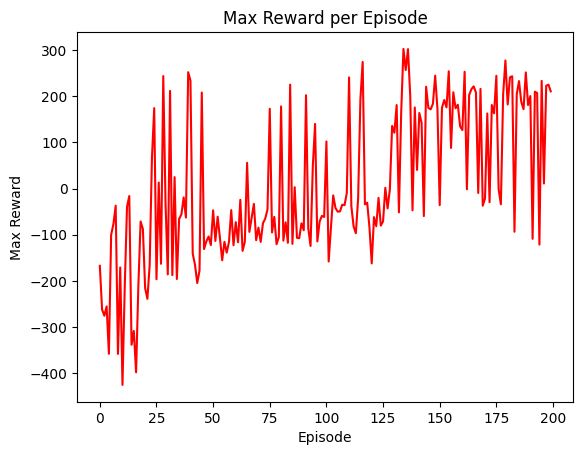

In [18]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Prueba 3
- Red Neuronal (Leaky Relu)
- Tamaño de Batch 128


In [19]:
transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, num_actions)  

    def forward(self, x):
        x = fun.leaky_relu(self.layer1(x))
        x = fun.leaky_relu(self.layer2(x))
        x = fun.leaky_relu(self.layer3(x))
        return self.layer4(x)  
        #devuelve predicciones de valores Q para cada acción posible

In [20]:
#PARÁMETROS
BATCH_SIZE = 128
GAMMA = 0.99  
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  
TAU = 0.001  
LR = 1e-4 


#REDES
policy_net = DQN(num_observations, num_actions)
target_net = DQN(num_observations, num_actions) 
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory(128)



#ENTRENAR
steps = 0
episode_durations = []

EPOCHS = 200
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
        memory.cache(state, action, next_state, reward)
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -285.2269302344789
Episodio 1 acabado con recompensa total: -40.133639958730924
Episodio 2 acabado con recompensa total: -319.9786397304234
Episodio 3 acabado con recompensa total: -32.4659795061187
Episodio 4 acabado con recompensa total: -464.21161604462554
Episodio 5 acabado con recompensa total: -473.90436138717723
Episodio 6 acabado con recompensa total: -455.4787467361759
Episodio 7 acabado con recompensa total: -305.2544714729826
Episodio 8 acabado con recompensa total: -104.44525341407476
Episodio 9 acabado con recompensa total: -361.42181600837097
Episodio 10 acabado con recompensa total: -349.3992668201477
Episodio 11 acabado con recompensa total: -242.0570250130143
Episodio 12 acabado con recompensa total: -241.25395310177532
Episodio 13 acabado con recompensa total: -228.94152735353168
Episodio 14 acabado con recompensa total: -191.20740773084856
Episodio 15 acabado con recompensa total: -120.26646079374464
Episodio 16 acabado con re

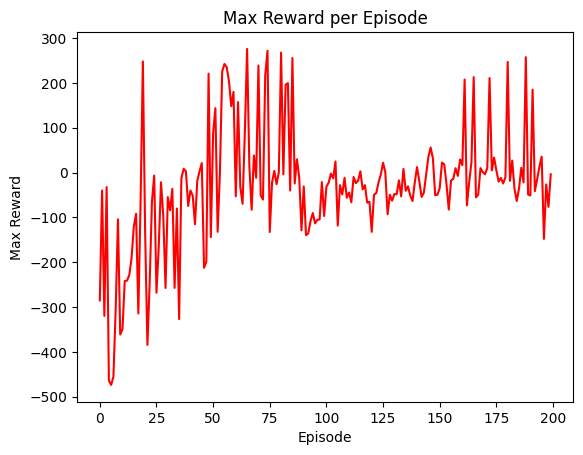

In [21]:
plot_durations(show_result=True)
plt.ioff()
plt.show()